# Objective

Writing is a hobby I've had for more than ten years now. I've written a lot during this time, from large novels to tiny tales, covering tutorials, essays, and formal reports. However, this raises the question: how much of a good writer am I? One way of evaluating that is by looking at how memorable my writing is. For example, one does not need to be told that a poem is from Shakespeare to identify it. Good writers have such a unique way of writing that they can be pinpointed right away.

This assignment aims to use machine learning to gather insights into my writing. By the end, we'll conclude whether I'm a skilled data scientist and a reasonable human being or whether I should pursue my passion of becoming an AH major.

# Dataset Description

The dataset used is comprised of writing samples from my Tumblr and Medium blogs, which can be downloaded as HMTL files in both websites. In total, 41 HTML files were gathered, each one representing a post (or a single text). The writing pieces were manually labeled into four categories:

1. Social criticism/opinion piece
2. Poem
3. Tale
4. Tutorial

Last, writing samples have different lengths, are from different times, and are all in Portuguese, which is my native language.

# Importing Dataset to Python

In [78]:
import os
import pandas as pd
from bs4 import BeautifulSoup
import nltk

# Download the NLTK punkt tokenizer data
nltk.download('punkt')

from nltk.tokenize import sent_tokenize

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/felipebandeira/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [94]:
# Define the folder containing HTML files
folder_path = '/Users/felipebandeira/Desktop/cs156/assignment 1/html'

# Initialize an empty list to store the data
data = []

# Iterate through each file in the folder
for filename in os.listdir(folder_path):
    if filename.endswith('.html'):
        # Extract category from filename
        category = filename.split(' ')[0]  # the category is the first part of the filename before underscore
        
        # Read the HTML file
        with open(os.path.join(folder_path, filename), 'r', encoding='utf-8') as file:
            content = file.read()

        # Parse the HTML content
        soup = BeautifulSoup(content, 'html.parser')
        
        # Extract the relevant content
        content_text = ' '.join([p.get_text() for p in soup.find_all('p')])
        
        # Tokenize the content into sentences
        sentences = sent_tokenize(content_text)
        
        # Add each sentence as a separate entry with the category
        for sentence in sentences:
            data.append({'Category': category, 'Content': sentence})

# Create a DataFrame using Pandas
df = pd.DataFrame(data)

In [122]:
print(df)

     Category                                            Content
0        poem  Se o fim entrasse em minha vista\nEntre risos ...
1        poem                   Por que não logo que tu me mata?
2        poem  Queima-me a pele e escalda-me a cabeça\nGargal...
3        poem  Não culpo a mim mesmo, pois eu que mereça\nMas...
4        poem  Atordoa-me até as últimas instâncias;\nAlicate...
...       ...                                                ...
1404     tale  Já passa das duas e eu fico a pensar…  (Recife...
1405     poem  Dor, sofrimento, combustãoPaisagem comum para ...
1406     poem        ):Vocês tem muita sorte d’eu não ser o Cão.
1407     poem  Mas então… MenteDesmenteSe sente contentePor a...
1408     poem  Pergunta difícil de se responderTão difícil qu...

[1409 rows x 2 columns]


# Data Processing

## Data preparation

Printing the dataset allows us to see how some of the observations look. Right away, we can see that some of the poems were not properly separated, and we have "\n" tokens within the text. Based on that, we can work on the data to fix it.

In [96]:
# Create an empty list to store the updated data
updated_data = []

# Iterate through each row in the DataFrame
for idx, row in df.iterrows():
    content = row['Content']
    
    # Split the content by '\n'
    lines = content.split('\n')
    
    # Add each line as a separate entry
    for line in lines:
        if line.strip():  # Check if line is not empty (to avoid adding empty entries)
            updated_data.append({'Category': row['Category'], 'Content': line.strip()})

# Create a new DataFrame with the updated data
updated_df = pd.DataFrame(updated_data)

# Print the updated DataFrame
print(updated_df)

     Category                                            Content
0        poem                   Se o fim entrasse em minha vista
1        poem         Entre risos perguntando “do que se trata?”
2        poem                            Puto, velho, vigarista!
3        poem                   Por que não logo que tu me mata?
4        poem             Queima-me a pele e escalda-me a cabeça
...       ...                                                ...
1603     tale  Já passa das duas e eu fico a pensar…  (Recife...
1604     poem  Dor, sofrimento, combustãoPaisagem comum para ...
1605     poem        ):Vocês tem muita sorte d’eu não ser o Cão.
1606     poem  Mas então… MenteDesmenteSe sente contentePor a...
1607     poem  Pergunta difícil de se responderTão difícil qu...

[1608 rows x 2 columns]


Printing random samples of the data a few times can help us identify whether there are other latent problems in the data.

In [59]:
# Randomly select 20 observations
random_observations = updated_df.sample(n=20) 

# Print the content of the selected observations
for idx, row in random_observations.iterrows():
    print(f"Content: {row['Content']}")


Content: Seus corpos desabam como o fizeram impérios que, um dia, foram invencíveis.
Content: Sentava na cama, esticava a coluna e cumpria o ritual com o suspiro de sempre.
Content: Sem mais delongas, é hora de irmos ao que importa.
Content: Que se foda.
Content: Que fez o coitado, mero simples sonhador?
Content: Essas são as classes específicas do seu aplicativo: não as que são comuns a todos e foram criadas pela Apple (como ViewController), mas as que só existem no seu app e foram criadas por você.
Content: É fácil falar de liberdade tendo tudo pago por mamãe e papai, mas a verdade é que ninguém na vida gosta de ter que escolher.
Content: Saindo da água, marcava seu caminho pela areia, permitindo que o mar lhe procurasse caso um infortúnio a impedisse de voltar.
Content: Assim: Passo 2: a seguir, abriremos a tradicional loadView, e nela criaremos uma variável qualquer para receber as características do nosso layout.
Content: Caiu no chão a
Content: As pessoas não entendiam por que mu

## Exploratory analysis

Before anything else, we should look into balance. How many entries are there in the dataframe for each category?

In [97]:
label_counts = updated_df['Category'].value_counts()
print(label_counts)

tale        922
tutorial    312
poem        309
opinion      65
Name: Category, dtype: int64


The dataset is very imbalanced, as we observe from the presence of 3 times more "tale" entries than tutorials or poems. This might skew the model and affect which performance metrics we can rely on, as we will discuss later on. 

# Task Explanation and Data Split

## Task explanation

To gather insights into my writing, we can start by analyzing how it changes according to its purpose. Specifically, is the way I write poems, for example, different from how I write tutorials or tales? 

If I am a great writer, we should expect that I have a unique writing style, that my pieces are unmistakable, and that one can identify which kind of text they're reading by having just a snippet. Therefore, I analyze: given a single sentence, how well can we predict the type of piece (poem, tale...) where it came from? This will be the focus of this assignment.

## Data split

From the original dataset, we can create two splits to train and validate our model.

In [99]:
from sklearn.model_selection import train_test_split

# Separates target variable from predictor variables (which, in this case, is just the Content column)
X = updated_df['Content']
y = updated_df['Category']

# Splits the data into training and testing sets, with the testing set containing 20% of the original dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)


# Model Selection

### **Naive Bayes Classifier**

In order to analyze whether my writing style changes according to the purpose at hand, we can pay attention to the vocabulary I use. Poems, for example, usually have a very different language than tutorial articles: it wouldn't be surprising to find in a poem a sentence such as "In this weary heart, love's flame grows pale," but one would never find such phrasing in a Medium piece on how to create a neural network. 


One model that is well suited for analyzing words across documents in the Naive Bayes Classifier (NBC). NBCs take advantage of the fact that some words are more likely to appear in one type of document than others, using this knowledge to predict what kind of document it is looking at, given the words it sees. Specifically, when fed with a string of text, NBCs calculates $P(\text{document}|\text{words})$ for multiple kinds of documents. It then outputs the document category with the highest probability. This probability is called posterior, and in order to calculate it, NBCs use Bayes' theorem and its components: priors and likelihoods. 

Priors are the probabilities of observing each kind of text (poem, tale, etc.) in the training corpus. To calculate $P(\text{document})$, the NBC simply counts the frequency of each document in the whole corpus, which is not a complex process.

$$
P(\text{document}) = \frac{\text{Count a specific type of document}}{\text{Number of documents in corpus D}}
$$

Likelihoods, on the other hand, are the probabilities of observing specific words in each kind of text, $P(\text{word}|\text{document})$. Calculating it is a bit more cumbersome: for each word and each document, we need to count the occurrence of that word across all documents of the same type and divide it by the total number of words in those documents.

$$
P(\text{word}|\text{document}) = \frac{\text{Count of a specific term t }}{\text{Number of terms in document d}}
$$


We bring these two together to calculate the posterior $P(\text{document}|\text{words})$. For a given set of $n$ words $W$:

$$
P(\text{document}|w_i, ..., w_j) = P(\text{document}) \prod_{i=1}^n{P(w_i|\text{document})}
$$

There is one small caveat to this: instead of calculating $P(\text{word}|\text{document})$ manually, we use an algorithm named TF-IDF.

### **TF-IDF**

To obtain the likelihoods that NBCs use, we can employ TF-IDF, which stands for Term Frequency-Inverse Document Frequency. In essence, this is a metric used to evaluate the importance of a word in a single document relative to a collection of documents (or corpus). We can break TF-IDF down in the following way:

#### Term Frequency (TF)
The first part of the metric, Term Frequency (TF), evaluates how frequently a term occurs in a document. It is calculated as the ratio of the number of times a specific term appears in a document to the total number of terms in the document.

Mathematically, TF is defined as:
$$
TF(t, d) = \frac{\text{Number of times term t appears in document d}}{\text{Total number of terms in document d}}
$$

A higher TF indicates that a term is more important in a document. <br><br><br>

#### Inverse Document Frequency (IDF)
We then have IDF, which measures the importance of a term across the corpus. It is calculated as the logarithm of the total number of documents divided by the number of documents that contain the term. Mathematically:

$$
IDF = \log \left(\frac{\text{Total number of documents in corpus D}}{\text{Number of documents containing term t}}\right)
$$

Terms that occur in many documents will have a lower IDF, while terms that occur in fewer documents will have a higher IDF. <br><br><br>

#### TF-IDF Score
If we multiply TF and IDF, we have the full TF-IDF score. It combines the importance of a term within a document (TF) with its importance across the corpus (IDF). Terms with high TF-IDF scores are considered important for a particular document, which is exactly the kind of metric we need for the NBC.

# Model Training

The code below performs the TF-IDF calculation and trains the Naive Bayes Classifier.

By calling `vectorizer.fit_transform(X_train)`, we look to learn about the training data and document frequencies. This would be equivalent to calling `vectorizer.fit(X_train)` and then `vectorizer.transform(X_train)`. The first call would execute the following steps:
1. **Tokenization**: breaks down the text into unitary parts, which are the tokens. 
2. **Building vocabulary**: builds up the vocabulary of different tokens in the training data; these terms become the columns in the TF-IDF matrix.
3. **Calculating Document Frequencies (DF)**: counts how many documents each term appears in, which will be used to calculate the IDF later.
4. **Calculating Term Frequencies (TF)**: counts how many times each term appears in each document in the training data, as described above.

Then, the second call (`vectorizer.transform(X_train)`) creates the full TF-IDF matrix. Each document (dataset entry) is transformed into a numerical vector that represents its TF-IDF scores for each term it contains. Consequently, the TF-IDF matrix `vec_texts` is a sparse matrix where each row corresponds to a dataset entry, and each column corresponds to a unique term. The entries represent the TF-IDF scores.

Last, we have `model.fit(vec_texts, y_train)`, which calculated the priors $P(\text{document})$ for each kind of text and creates the structure for quickly calculating the posterior $P(\text{document}|\text{terms})$ once inputs arrive. Once this is in place, the model is considered trained.

In [100]:
from sklearn.feature_extraction import text
from sklearn import metrics, naive_bayes

vectorizer = text.TfidfVectorizer() 
vec_texts = vectorizer.fit_transform(X_train)

model = naive_bayes.MultinomialNB()
model.fit(vec_texts, y_train)

MultinomialNB()

# Predictions and Performance

### Creating a single prediction

In order to create predictions, we need to first vectorize the input text using the matrix we created above, and then give it to the model for a category to be predicted. This can be done with the script below:

In [101]:
def make_prediction(text):
    vectorized_sample_text = vectorizer.transform([text])
    prediction = model.predict(vectorized_sample_text)

    print(f"Original text: {text}")
    print(f"Model prediction: {prediction}")

If we write, for example, a text such as "This text was created to test the model", the model will predict:

In [116]:
# Translating the phrase, because the model was trained with text in Portuguese
make_prediction("Este texto foi criado para testar o modelo")

Original text: Este texto foi criado para testar o modelo
Model prediction: ['tale']


### Model performance over the test set

After the test set was created, we can have a look into it to understand its composition. Although there still is a disproportional amount of tales, samples from all categories can be found.

In [103]:
print("Real composition of the test set:")
print(y_test.value_counts())

Real composition of the test set:
tale        191
tutorial     74
poem         45
opinion      12
Name: Category, dtype: int64


Evaluating the model's predictons, however, we can notice something seems wrong: the model overpredicts tales (the category with the largest presence in the dataset) and does not predict two of the four categories at all.

In [105]:
# Vectorizing test set
vec_texts_test = vectorizer.transform(X_test)

# Generating predictions for it
pred_y = model.predict(vec_texts_test)

# This function counts the frequency of words in a list
def count_words(word_list):
    word_counts = {}
    for word in word_list:
        if word in word_counts:
            word_counts[word] += 1
        else:
            word_counts[word] = 1
    return word_counts

word_counts = count_words(pred_y)

print("Predicted composition of the test set:")
for word, count in word_counts.items():
    print(f'{word}: {count}')

Predicted composition of the test set:
tale: 300
tutorial: 22


We can better observe the NBC's performance through a confusion matrix. As we see below, the model correctly classifies all 198 tales. However, it also classifies all opinion articles, poems, and half of the tutorials as tales, making it overconfident for this category.

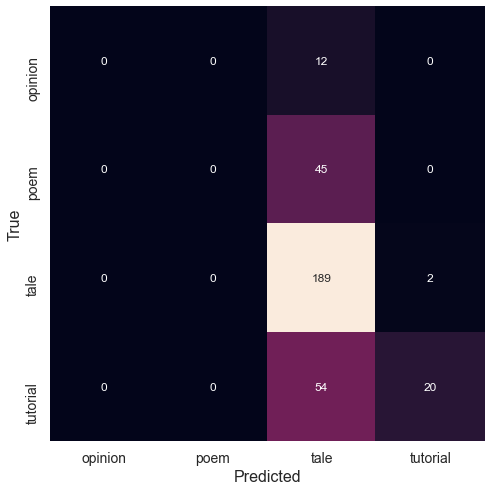

In [106]:
import matplotlib.pyplot as plt
import seaborn as sns

# Extracting labels from the test set for plotting
labels = sorted(y_test.unique())

# Plotting
plt.figure(figsize=(10, 8))
confusion_mat = metrics.confusion_matrix(y_test, pred_y)
sns.heatmap(confusion_mat, square=True, annot=True, fmt='d', cbar=False, xticklabels=labels, yticklabels=labels, annot_kws={'size': 12})
plt.xlabel('Predicted', fontsize=16)
plt.ylabel('True', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

This is directly caused by the imbalance in the data. As previously explained, NBCs use priors and likelihoods to predict categories. Specifically:

$$
p(\text{category}|\text{words}) = p(\text{words}|\text{category}) . p(\text{category})
$$

With an imbalanced dataset, the prior $p(\text{category})$ dominates the calculation, decreasing the relevance of the likelihood. This is why our model is overconfident about tales: in the original dataset, tales were three times more common than poems or tutorials, and fourteen times more common than opinion articles!

### Performance metrics

To evaluate how the model is performing, we could start with **accuracy**. This evaluates, out of all instances in the test set, how many were correctly classified. Mathematically speaking:

$$
\text{Accuracy} = \frac{\text{True poems + True tales + True tutorials + True opinion articles}}{\text{All (poems + tales + tutorials + opinion articles)}}
$$

Below, we can see an accuracy of 0.64, which is only a bit better than a random guess. However, accuracy is not a metric we should rely on, given how imbalanced the dataset is. One of the consequences of imbalanced data is that, depending on the imbalance, even if the model is only predicting a single label (like ours mostly is), we can still get a high accuracy score.

In [117]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Accuracy
accuracy = accuracy_score(y_test, pred_y)

print(f'Accuracy: {accuracy}')

Accuracy: 0.6490683229813664


Instead, other metrics can be more informative, such as precision, recall, and F1. 

##### Precision
This metric focuses on the accuracy of positive predictions. It answers the question: "out of everything that was predicted positive, how much was actually right?" In our case, precision tells us the proportion of correctly predicted instances for a specific text category compared to all instances predicted to be part of that category.

$$
\text{Precision} = \frac{\text{True Positives}}{\text{True Positives + False Positives}}
$$

Here, we will have one precision score for each category, which are then averaged considering the weight of the number of observations in each clas:

$$
\text{Weighted Precision} = \frac{\sum_{i=1}^{n} \text{Precision}_i \cdot \text{Support}_i}{\sum_{i=1}^{n} \text{Support}_i}
$$

Here:
- $\text{Precision}_i$ is the precision for class _i_
- $\text{Support}_i$ is the number of samples for class _i_
- $n$ is the total number of classes

##### Recall
Recall answers a slightly different question: out of all texts that _should have been_ predicted as being from a given class, how many were indeed identified? 

$$
\text{Recall} = \frac{\text{True Positives}}{\text{True Positives + False Negatives}}
$$

We again weight the results, like we did with Precision scores.

##### F1 Score
This metric combines precision and recall to provide a balanced evaluation of the model's performance. Mathematically, it is the harmonic mean of precision and recall.

$$
\text{F1 Score} = 2 \times \frac{\text{Precision} \times \text{Recall}}{\text{Precision + Recall}}
$$

In [120]:
# Precision
precision = precision_score(y_test, pred_y, average='weighted')

# Recall
recall = recall_score(y_test, pred_y, average='weighted')

# F1-Score
f1 = f1_score(y_test, pred_y, average='weighted')

print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1-Score: {f1}')

Precision: 0.5826171654432524
Recall: 0.6490683229813664
F1-Score: 0.5524102583564197


As observed, the model performs poorly as a whole, and we cannot really draw conclusions about the dataset.

# Extra section: balancing the data

To show the impact of balancing the dataset, I have done that below. The following code cells remove 65% of the "tale" observations from the dataset, making different categories more similar. Then, it performs all of the steps we did above to create the model and make predictions.

In [146]:
# Define the condition
condition = (updated_df['Category'] == 'tale')

# Get the indices of rows where Category is 'tale'
tale_indices = updated_df[condition].index

# Calculate the number of rows to remove (65% of 'tale' rows)
num_rows_to_remove = int(0.65 * len(tale_indices))

# Randomly select and remove 60% of 'tale' rows
rows_to_remove = updated_df.loc[tale_indices].sample(n=num_rows_to_remove)
trimmed_df = updated_df.drop(rows_to_remove.index)

label_counts = trimmed_df['Category'].value_counts()
print(label_counts)


tale        323
tutorial    312
poem        309
opinion      65
Name: Category, dtype: int64


In [151]:
# Separates target variable from predictor variables (which, in this case, is just the Content column)
X = trimmed_df['Content']
y = trimmed_df['Category']

# Splits the data into training and testing sets, with the testing set containing 20% of the original dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [152]:
# Vectorizes the text and trains the model
vectorizer = text.TfidfVectorizer() 
vec_texts = vectorizer.fit_transform(X_train)

model = naive_bayes.MultinomialNB()
model.fit(vec_texts, y_train)

MultinomialNB()

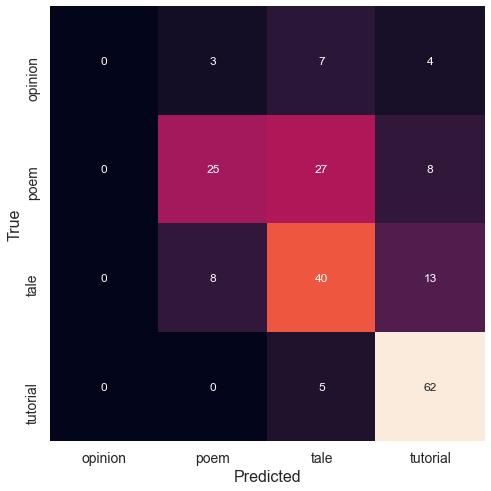

In [153]:
# Vectorizing test set
vec_texts_test = vectorizer.transform(X_test)

# Generating predictions for it
pred_y = model.predict(vec_texts_test)

# Extracting labels from the test set for plotting
labels = sorted(y_test.unique())

# Plotting
plt.figure(figsize=(10, 8))
confusion_mat = metrics.confusion_matrix(y_test, pred_y)
sns.heatmap(confusion_mat, square=True, annot=True, fmt='d', cbar=False, xticklabels=labels, yticklabels=labels, annot_kws={'size': 12})
plt.xlabel('Predicted', fontsize=16)
plt.ylabel('True', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

In [155]:
# Accuracy
accuracy = accuracy_score(y_test, pred_y)

# Precision
precision = precision_score(y_test, pred_y, average='weighted')

# Recall
recall = recall_score(y_test, pred_y, average='weighted')

# F1-Score
f1 = f1_score(y_test, pred_y, average='weighted')

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1-Score: {f1}')

Accuracy: 0.6287128712871287
Precision: 0.5955439062020563
Recall: 0.6287128712871287
F1-Score: 0.5943326475504694


Interesting enough, the model did not become much more accurate than before. However, we can now be sure that it is not being overconfident about one of the categories anymore! According to the results, my tutorials are "very original", having a vocabulary of their own (which is understandable, given that I use technical terms in them, which do not appear in anything else I wrote). My poems, however, do not seem to be much different from my tales, meaning that maybe I should stay away from AH courses!

# Executive summary
In the previous sections, we tried to gather insights about my writing style over the past ten years. We started by importing data from my Tumblr and Medium blogs, which were transferred to a dataframe and cleaned. Then, we split the data into training and test sets, which were vectorized with TF-IDF and passed to an NBC.

At first, the NBC was overconfident about one of the categories due to a significant dataset imbalance. When analyzing its performance, it was not much better than a coin thrown in the air. We then reduced the dataset to decrease the model's bias and explored how it performs again. The model performance per se did not change much, but this time, we could learn something from the results: although my tutorials have a language of their own, the vocabulary I use for poems and tales is very similar, and one cannot distinguish accurately between both when given a single sentence to read.

Despite these results, we must note that the question we initially posed cannot be fully answered by an NBC — even if we had one working well. This happens because, if we had a highly accurate classifier, we could conclude that our writing style indeed varies for different kinds of texts: if poems and tales can be differentiated based on vocabulary, they are definitely very different from each other.

However, if the NBC told us we are unable to differentiate texts based on vocabulary, we would _not_ be able to conclude my writing across all categories is the same. Naive Bayes Classifiers assume independence between words and do not account for higher-level characteristics, such as how words are positioned in a phrase. Consequently, the sentence "I start my day with sun" would be identical to "With sun I start my day" for an NBC, even though one is more likely to be in a poem, for example, than the other.

To account for such differences, we would need more advanced models, such as Transformer-based models that can use attention.

# References

How to Create Naive Bayes Document Classification in Python?
- https://www.turing.com/kb/document-classification-using-naive-bayes
- https://www.datacamp.com/tutorial/naive-bayes-scikit-learn
- https://medium.com/@eiki1212/natural-language-processing-naive-bayes-classification-in-python-e934365cf40c

TF-IDF vectorizer documentation
- https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html

TF-IDF theory (the book below, Chapter 6)
- https://web.stanford.edu/~jurafsky/slp3/

PCW code from Session 3.1

# HCs

**rightproblem**: Based on a goal of getting insights about my writing, I narrowed down and framed the problem in a tractable way: analyzing whether the vocabulary I used for different kinds of text was the same. I then designed an experiment to tackle the problem, made a critique to it (imbalanced data led to model unreliability), redesigned the solution, and critiqued the outcomes again (although the model is more reliable in terms of design, it is not appropriate to address the question at hand because it assumes words are independent).

**modeling**: Given the problem at hand (classifying texts based on their words), I identified a suitable model (Naive Bayes), explained why it was relevant, walked through how it works, analyzed its results, and explained its limitations.

**plausibility**: When discussing how appropriate Naive Bayes was, I explained its relevance for the task, but also its limitations given the assumptions it makes (independence between words). I also explained the assumptions behind accuracy, emphasizing and exemplifying why it is not a suitable metric for imbalanced datasets.

**composition**: Throughout the assignment, I avoided highly technical terms and explained all concepts in an accessible way. Paragraphs were carefully reviewed not to be tiring, long sentences were avoided, and examples were provided when necessary to enhance clarity. 

# AI Statement

AI was extensively used in this assignment, mostly for simple coding tasks (e.g.: "plot me a graph") or for checking my own explanations.